<a href="https://colab.research.google.com/github/abhayforML/DNN_architecture-tuner/blob/main/Gr1_architecture_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Group1 - Abhay(01), Moutushi(14), Meenakshi(12)
##Getting the best/optimum loss and accuracy using tuner 

###In the earlier submitted architecture of DNN where input is Avg returns and output is var covar matrix.  The loss shown was much higher.

####Note: Int this project avg returns are generated from 3000 sample (taken from) 2 year past data. So the historical data is increased and the number of input samples too. However, that does not reduce the loss much further. This project attempts to use the 'tuner' funtion of Keras.


###Step1: Download prices for for 4 selected stocks and calculate returns.
###Number of stocks can be expanded later.
###Use the function loadprices.

In [ ]:
import pandas as pd
import numpy as np

symbol = 'reliance' # specify the yahoo symbol like infy, reliance, sbin etc.
years = 2       # specify the number of years (You can change this to number of days, in that case remove multiplication of 365 in variable 'start')

# Rewrite another similar program which takes a specific period and output prices of a given stock.

def loadprices(symbol, years = 1):
  from urllib.request import urlopen
  import math
  import datetime
  end = ((datetime.date.today() - datetime.date(1970, 1, 2)).days)*24*3600
  start = end - years*365*24*3600
  if symbol == 'NSEI':                      #ignore this code as we do not use NSEI
    link = 'https://query1.finance.yahoo.com/v7/finance/download/'+ '%5ENSEI'.upper() +'?period1='+ str(start) + \
    '&period2='+ str(end) +'&interval=1d&events=history&includeAdjustedClose=true'
  else:
    link = 'https://query1.finance.yahoo.com/v7/finance/download/'+ symbol.upper() +'.NS?period1='+ str(start) + \
    '&period2='+ str(end) +'&interval=1d&events=history&includeAdjustedClose=true'
  print(link)
  f = urlopen(link)
  data = f.read()
  data = data.decode('utf-8')
  data = data.split('\n')
  daily_adjusted_close = []
  for line in data[1:]:
    # line is a str type
    row = line.split(',')
    if row[0] == '2020-11-14':
        print(row)                      #Check nulls
        #r1 = list(map(lambda x : '0.0' if x == 'null' else x ,row)) #fix nulls
        #row = r1
        #continue                        #skip NaN row
    # row is a list of 7 elements
    daily_adjusted_close.append(float(row[5]))
  return(daily_adjusted_close)
  

#portstocks = ['NSEI', 'TCS', 'ASIANPAINT', 'SBIN', 'DABUR', 'ADANIPORTS']
portstocks = ['TCS', 'ASIANPAINT', 'SBIN', 'DABUR','CIPLA','ADANIPORTS']

stocklist = [] # list to collect adj close prices
for stk in portstocks:
  stocklist.append(loadprices(stk, years))

stocks_df = pd.DataFrame(stocklist, index=[portstocks]).T

print('Prices daily adj close...prices give 1 extra')
#print(stocks_df.isna())
print(stocks_df.shape)

stocks_rtn = stocks_df.pct_change().dropna()
#print(stocks_rtn.isna().sum())
#Stock returns is a pandas dataframe

print('\nStock returns\n', stocks_rtn.shape, '\n')
#print last 2 year's data
#print(stocks_rtn)


https://query1.finance.yahoo.com/v7/finance/download/TCS.NS?period1=1601078400&period2=1664150400&interval=1d&events=history&includeAdjustedClose=true
['2020-11-14', '2677.949951', '2689.000000', '2660.050049', '2670.350098', '2612.288330', '298819']
https://query1.finance.yahoo.com/v7/finance/download/ASIANPAINT.NS?period1=1601078400&period2=1664150400&interval=1d&events=history&includeAdjustedClose=true
['2020-11-14', '2192.000000', '2193.399902', '2180.350098', '2184.600098', '2158.833984', '146991']
https://query1.finance.yahoo.com/v7/finance/download/SBIN.NS?period1=1601078400&period2=1664150400&interval=1d&events=history&includeAdjustedClose=true
['2020-11-14', '232.000000', '232.899994', '227.750000', '229.649994', '224.052551', '7753219']
https://query1.finance.yahoo.com/v7/finance/download/DABUR.NS?period1=1601078400&period2=1664150400&interval=1d&events=history&includeAdjustedClose=true
['2020-11-14', '520.000000', '522.000000', '515.500000', '517.150024', '509.917419', '4382

###Step2: For our DNN we should input the Avg stock returns and output the Var-Covar matrix.

DNN requires more observations typically in 1000s or more. 
In this experiment, We here generate 3000 random samples from our 2 year of data, selected consecutive 90 rows at a time. 

i.e. Each sample of 90 consecutive rows will generate a different "mean returns for those 90 days". This is our input.


In [ ]:
import random

nrows = stocks_rtn.shape[0]
#(ncols = stocks_rtn.shape[,0]
#496 rows
print(nrows)

#Initialize a row vector 16x1
temp_arr = np.zeros(36, dtype=float)
temp_avg_rtn_arr = np.zeros((6,1), dtype=float)

#Genrate 3000 samples of consecutive 90 rows
#90 taken to resemble a qtr 
for i in range(2999):
    #ix will give any number between 0,496-90
    ix = random.randint(0,nrows-90)
    #print('sample #',i)                             #prints sample #
    sample_rtn = stocks_rtn.iloc[ix:ix+90, :]       #sample drawn
    #print(sample_rtn)                              #prints sample
    s_avg_rtn = sample_rtn.sum(axis=0)/90           #all cols avged
    sample_avg_rtn = s_avg_rtn.to_frame(name=None)  #df
    #print(sample_avg_rtn.T)                        #prints avg 1x5
    sample_avg_rtn_arr = sample_avg_rtn.to_numpy()  #np
    sample_vc = sample_rtn.cov()                    #df cov of rtn
    if i == 2999:
        print('Last Cov array to compare')
        print(sample_vc)                               #prints last cov matrix 5x5
    sample_vc_arr = sample_vc.to_numpy()            #np
    sample_vc_vec = sample_vc_arr.flatten(order='C')#flattened cov
    #print(sample_vc_vec.shape)                     #25x1
    temp_arr = np.append(temp_arr, sample_vc_vec, axis=0)

    temp_avg_rtn_arr = np.append(temp_avg_rtn_arr, sample_avg_rtn_arr, axis=0)
    #print(temp_arr.shape)
final_arr = np.reshape(temp_arr, (3000, 36), order='C')
final_arr = np.delete(final_arr,0,0)
print('*****************Cov')
print('3000 Cov flattend arrays')
print(final_arr)
#print(final_arr.shape)
print('*****************')

print('*****************Rtn')
print('3000 rtns arrays')
final_rtn_arr = np.reshape(temp_avg_rtn_arr, (3000, 6), order='C')
final_rtn_arr = np.delete(final_rtn_arr,0,0)        #remove first one
print(final_rtn_arr)
#print(final_rtn_arr.shape)
print('*****************')

#convert back to Dataframe the Cov
final_arr = np.delete(final_arr,0,0)
allsample_vc_vecs = pd.DataFrame(data=final_arr).dropna()
#pd.set_option('display.max_rows', None)
#print(type(allsample_vc_vecs))


allsample_avg_rtn = pd.DataFrame(data=final_rtn_arr).dropna()
final_rtn_arr = np.delete(final_rtn_arr,0,0)



#print(allsample_vc_vecs[allsample_vc_vecs.isnull().any(axis=1)])
#print(allsample_avg_rtn[allsample_avg_rtn.isnull().any(axis=1)])
#df[df.isnull().any(axis=1)]
print(final_arr.shape)
print(final_rtn_arr.shape)

494
*****************Cov
3000 Cov flattend arrays
[[ 2.12855449e-04  1.14694468e-04  1.00213070e-04 ...  1.46764528e-04
   4.47813821e-05  4.39935260e-04]
 [ 1.78481447e-04  6.40675105e-05  2.97026659e-05 ...  3.83336912e-05
  -2.58389342e-05  4.50951892e-04]
 [ 2.18406912e-04  8.55314587e-05  4.69935606e-05 ...  7.53716913e-05
   9.03209016e-05  5.90673988e-04]
 ...
 [ 1.27314920e-04  4.44840082e-05  9.82796711e-06 ...  4.62247413e-05
   5.69319517e-06  9.46559923e-04]
 [ 2.65389900e-04  1.75563539e-04  1.43013152e-04 ...  2.34660695e-04
   1.51467865e-04  6.43144427e-04]
 [ 1.27577941e-04  4.35072739e-05  1.02438208e-05 ...  4.65820278e-05
   5.83159618e-06  9.47327457e-04]]
*****************
*****************Rtn
3000 rtns arrays
[[-6.55405815e-05 -3.56142520e-04  3.33882929e-04 -4.20030712e-04
   8.70186990e-04  1.60925663e-03]
 [-1.27394643e-05 -2.27919484e-04  1.75228288e-03 -1.03873345e-03
  -3.28537084e-04 -1.44850469e-04]
 [ 2.01426203e-03  2.00842161e-03  4.88595176e-03  6.161

###Step3: Import Keras libraries
###Define X_data, Y_data
### Y_Data is the expected output var-covariance flattened matrix 
### X_Data is the actual avg rtns of 2998 samples

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

#kera libraries below
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.metrics import categorical_crossentropy
!pip install keras-tuner -q
import keras_tuner

#Everything is numeric..nothing to transform from alpha to numeric in preprocessing
#No Label encoding is  required in the pre-processing otherwise 
#from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
#Refer to DNNkeras_group1 if need be for tranformations


Y_data = allsample_vc_vecs
print(Y_data.shape)
X_data = final_rtn_arr
print(X_data.shape)

x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(X_data, Y_data, test_size=0.2, random_state=1)


(2998, 36)
(2998, 6)


##Write build_model function with different typer parameters

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    #model.add(layers.Flatten())            Not needed as this is not CNN
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=36, max_value=360, step=36),
                input_dim=6,
                activation=hp.Choice("activation", ['relu']),
            )
        )
    if hp.Boolean("dropout"):               #default is false
        model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(36, activation="relu"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="MSE",
        metrics=["accuracy"],
    )
    return model


#build_model(keras_tuner.HyperParameters()) #this is a test for bult model
#print(keras_tuner.HyperParameters())

##RandomSearch optimization using tuner
###We are taking 5 trials and 5 executions per trial
###Tuner calls buld_model functions


In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=5,
    executions_per_trial=5,
    overwrite=True,
    directory="content",
    project_name="Group1_architecture",
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 36, 'max_value': 360, 'step': 36, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(x_train, y_train, epochs=4, validation_data=(x_val, y_val))

Trial 5 Complete [00h 00m 13s]
val_loss: 3.279033933267783e-08

Best val_loss So Far: 7.886443320614945e-09
Total elapsed time: 00h 00m 46s


In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]          #The first in the list
best_hps = tuner.get_best_hyperparameters(5)            #used later

# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None,6))
best_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 108)               756       
                                                                 
 dense_1 (Dense)             (None, 36)                3924      
                                                                 
 dense_2 (Dense)             (None, 36)                1332      
                                                                 
Total params: 6,012
Trainable params: 6,012
Non-trainable params: 0
_________________________________________________________________


##Fit your own final model with hyper parameters received
###Get hyper parameters from tuner and train the model with full data


In [ ]:
final_model = build_model(best_hps[0])

x_all = np.concatenate((x_train, x_val))
y_all = np.concatenate((y_train, y_val))

history = final_model.fit(x=x_all, y=y_all, epochs=4)
final_model.summary()
scores = final_model.evaluate(x_train, y_train)

print("\n%s: %.2f%%" % (final_model.metrics_names[1], scores[1]*100))

Epoch 1/4
94/94 [==============================] - 1s 2ms/step - loss: 9.7398e-09 - accuracy: 0.9146
Epoch 2/4
94/94 [==============================] - 0s 2ms/step - loss: 8.5282e-09 - accuracy: 0.9536
Epoch 3/4
94/94 [==============================] - 0s 1ms/step - loss: 8.3925e-09 - accuracy: 0.9613
Epoch 4/4
94/94 [==============================] - 0s 2ms/step - loss: 8.4451e-09 - accuracy: 0.9696
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 108)               756       
                                                                 
 dense_4 (Dense)             (None, 36)                3924      
                                                                 
 dense_5 (Dense)             (None, 36)                1332      
                                                                 
Total params: 6,012
Trainable params: 6,012
No

In [ ]:
tuner.results_summary()

Results summary
Results in content/Group1_architecture
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 2
units_0: 108
activation: relu
dropout: False
lr: 0.00023368356870813616
units_1: 36
Score: 7.886443320614945e-09
Trial summary
Hyperparameters:
num_layers: 2
units_0: 36
activation: relu
dropout: True
lr: 0.00039212961505715734
units_1: 216
Score: 1.2824146899959033e-08
Trial summary
Hyperparameters:
num_layers: 2
units_0: 144
activation: relu
dropout: False
lr: 0.0009621896931286941
units_1: 36
Score: 2.192243542253891e-08
Trial summary
Hyperparameters:
num_layers: 1
units_0: 108
activation: relu
dropout: False
lr: 0.0014850075634018692
Score: 2.981964719594998e-08
Trial summary
Hyperparameters:
num_layers: 3
units_0: 288
activation: relu
dropout: True
lr: 0.0065485139280741555
units_1: 360
units_2: 36
Score: 3.279033933267783e-08


###Step4: Use a simple DNN first and use LOSS Function that is optimized (MSE)

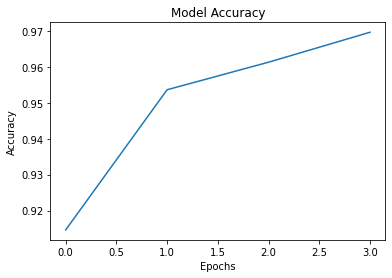

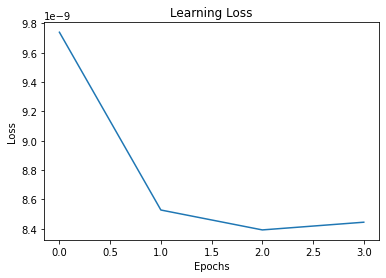

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

plt.plot(history.history['loss'])
plt.title('Learning Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

!pip install ann_visualizer

from ann_visualizer.visualize import ann_viz
ann_viz(final_model, view=True, filename='projectDNN.gv', title='Gr1 Neural Network tuning')